# Class Diagrams

This is a simple viewer for class diagrams.  Customized towards the book.

**Prerequisites**

* _Refer to earlier chapters as notebooks here, as here:_ [Earlier Chapter](Debugger.ipynb).

In [1]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.ClassDiagram import <identifier>
```

and then make use of the following features.


The function `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes). The keyword parameter `public_methods`, if given, is a list of "public" methods to be used by clients (default: all methods with docstrings).

```python
>>> display_class_hierarchy(D_Class)
```

![](PICS/ClassDiagram-synopsis-1.svg)
```

>>> display_class_hierarchy([A_Class, B_Class],
>>>                         public_methods=[
>>>                             A_Class.quux,
>>>                         ])
```

![](PICS/ClassDiagram-synopsis-2.svg)

Enjoy!



## Getting a Class Hierarchy

Using `mro()`, we can access the class hierarchy.  We make sure to avoid duplicates created by `class X(X)`.

In [2]:
def class_hierarchy(cls):
    superclasses = cls.mro()
    hierarchy = []
    last_superclass_name = ""
    for superclass in superclasses:
        if superclass.__name__ != last_superclass_name:
            hierarchy.append(superclass)
            last_superclass_name = superclass.__name__
    return hierarchy

Here's an example:

In [3]:
class A_Class:
    """A Class which does A thing right.
    Comes with a longer docstring."""
    def foo(self):
        """The Adventures of the glorious Foo"""
        pass

    def quux(self):
        """A method that is not used."""
        pass

In [4]:
class B_Class(A_Class):
    """A subclass inheriting some methods."""
    def foo(self, fight=False):
        """A WW2 foo fighter."""
        pass
    def bar(self, qux=None, bartender=42):
        """A qux walks into a bar.
        `bartender` is an optional attribute."""
        pass

In [5]:
class C_Class:
    def qux(self):
        pass

In [6]:
class D_Class(B_Class, C_Class):
    """A subclass inheriting from multiple superclasses.
    Comes with a fairly long, but meaningless documentation."""
    def foo(self):
        B_Class.foo(self)

In [7]:
class_hierarchy(D_Class)

[__main__.D_Class,
 __main__.B_Class,
 __main__.A_Class,
 __main__.C_Class,
 object]

## Getting a Class Tree

We can use `__bases__` to obtain the immediate base classes.

In [8]:
D_Class.__bases__

(__main__.B_Class, __main__.C_Class)

In [9]:
def class_tree(cls):
    def base_tree(base):
        while base.__name__ == cls.__name__:
            base = base.__bases__[0]
        return class_tree(base)

    ret = []
    for base in cls.__bases__:
        ret.append((cls, base_tree(base)))
    return ret

In [10]:
class_tree(D_Class)

[(__main__.D_Class, [(__main__.B_Class, [(__main__.A_Class, [])])]),
 (__main__.D_Class, [(__main__.C_Class, [])])]

Not perfect yet (multiple instances of same class), but we're getting there.

`class_set()` flattens the tree into a set:

In [11]:
def class_set(classes):
    if not isinstance(classes, list):
        classes = [classes]

    ret = set()
    def traverse_tree(tree):
        for (cls, subtrees) in tree:
            ret.add(cls)
            for subtree in subtrees:
                traverse_tree(subtrees)

    for cls in classes:
        traverse_tree(class_tree(cls))

    return ret

In [12]:
class_set(D_Class)

{__main__.A_Class, __main__.B_Class, __main__.C_Class, __main__.D_Class}

In [13]:
class_set([B_Class, C_Class])

{__main__.A_Class, __main__.B_Class, __main__.C_Class}

## Getting methods

In [14]:
import inspect

In [15]:
def class_methods(cls):
    def _class_methods(cls):
        all_methods = inspect.getmembers(cls, lambda m: inspect.isfunction(m))
        for base in cls.__bases__:
            all_methods += _class_methods(base)

        return all_methods

    unique_methods = []
    methods_seen = set()
    for (name, fun) in _class_methods(cls):
        if name not in methods_seen:
            unique_methods.append((name, fun))
            methods_seen.add(name)

    return unique_methods

In [16]:
class_methods(D_Class)

[('bar', <function __main__.B_Class.bar(self, qux=None, bartender=42)>),
 ('foo', <function __main__.D_Class.foo(self)>),
 ('quux', <function __main__.A_Class.quux(self)>),
 ('qux', <function __main__.C_Class.qux(self)>)]

We're only interested in 

* functions _defined_ in that class
* functions that come with a docstring

In [17]:
def public_class_methods(cls):
    return [(name, method) for (name, method) in class_methods(cls) 
            if method.__qualname__.startswith(cls.__name__)]

In [18]:
def doc_class_methods(cls):
    return [(name, method) for (name, method) in public_class_methods(cls) 
            if method.__doc__ is not None]

In [19]:
public_class_methods(D_Class)

[('foo', <function __main__.D_Class.foo(self)>)]

In [20]:
doc_class_methods(D_Class)

[]

In [21]:
def overloaded_class_methods(classes):
    all_methods = {}
    for cls in class_set(classes):
        for (name, method) in class_methods(cls):
            if method.__qualname__.startswith(cls.__name__):
                all_methods.setdefault(name, set())
                all_methods[name].add(cls)
            
    return [name for name in all_methods if len(all_methods[name]) >= 2]

In [22]:
overloaded_class_methods(D_Class)

['foo']

## Drawing Class Hierarchy with Method Names

In [23]:
import html

In [24]:
import re

In [25]:
def escape(text):
    text = html.escape(text)
    assert '<' not in text
    assert '>' not in text
    text = text.replace('{', '&#x7b;')
    text = text.replace('|', '&#x7c;')
    text = text.replace('}', '&#x7d;')
    return text

In [26]:
escape("f(foo={})")

'f(foo=&#x7b;&#x7d;)'

In [27]:
def escape_doc(docstring):
    DOC_INDENT = 4
    docstring = "&#x0a;".join(
        ' ' * DOC_INDENT + escape(line).strip()
        for line in docstring.split('\n')
    )
    return docstring

In [28]:
print(escape_doc("'Hello\n    {You|Me}'"))

    &#x27;Hello&#x0a;    &#x7b;You&#x7c;Me&#x7d;&#x27;


In [29]:
from inspect import signature

In [30]:
import warnings

In [31]:
def display_class_hierarchy(classes, 
                            public_methods=None,
                            include_methods=True,
                            include_legend=True,
                            project='fuzzingbook'):
    """Visualize a class hierarchy.
`classes` is a Python class (or a list of classes) to be visualized.
`public_methods`, if given, is a list of methods to be shown as "public" (bold).
  (Default: all methods with a docstring)
`include_methods`: if True, include all methods (default)
`include_legend`: if True, include a legend (default)
    """
    from graphviz import Digraph

    if project == 'debuggingbook':
        CLASS_FONT = 'Raleway, Helvetica, Arial, sans-serif'
        CLASS_COLOR = '#6A0DAD'  # HTML 'purple'
    else:
        CLASS_FONT = 'Patua One, Helvetica, sans-serif'
        CLASS_COLOR = '#B03A2E'

    METHOD_FONT = "'Fira Mono', 'Source Code Pro', 'Courier', monospace"
    METHOD_COLOR = 'black'

    if isinstance(classes, list):
        starting_class = classes[0]
    else:
        starting_class = classes
        classes = [starting_class]

    title = starting_class.__name__ + " class hierarchy"

    dot = Digraph(comment=title)
    dot.attr('node', shape='record', fontname=CLASS_FONT)
    dot.attr('graph', rankdir='BT', tooltip=title)
    dot.attr('edge', arrowhead='empty')
    edges = set()
    overloaded_methods = set()

    def method_string(method_name, public, overloaded, fontsize=10):
        method_string = f'<font face="{METHOD_FONT}" point-size="{str(fontsize)}">'

        if overloaded:
            name = f'<i>{method_name}()</i>'
        else:
            name = f'{method_name}()'

        if public:
            method_string += f'<b>{name}</b>'
        else:
            method_string += f'<font color="{METHOD_COLOR}">' \
                             f'{name}</font>'

        method_string += '</font>'
        return method_string

    def is_overloaded(method_name, f):
        return (method_name in overloaded_methods or
                (f.__doc__ is not None and "in subclasses" in f.__doc__))

    def is_public(method_name, f):
        if public_methods:
            return method_name in public_methods or f in public_methods
        else:
            return f.__doc__ is not None

    def class_methods_string(cls, url):
        methods = public_class_methods(cls)
        # return "<br/>".join([name + "()" for (name, f) in methods])
        if len(methods) == 0:
            return ""

        methods_string = f'<table border="0" cellpadding="0" ' \
                         f'cellspacing="0" ' \
                         f'align="left" tooltip="{cls.__name__}" href="#">'

        for public in [True, False]:
            for (name, f) in methods:
                if public != is_public(name, f):
                    continue
                    
                if is_public(name, f) and not f.__doc__:
                    warnings.warn(f"{f.__qualname__}() is listed as public,"
                                  f" but has no docstring")

                overloaded = is_overloaded(name, f)

                method_doc = escape(name + str(inspect.signature(f)))
                if f.__doc__:
                    method_doc += ":&#x0a;" + escape_doc(f.__doc__)

                # Tooltips are only shown if a href is present, too
                tooltip = f' tooltip="{method_doc}"'
                href = f' href="{url}"'
                methods_string += f'<tr><td align="left" border="0"' \
                                  f'{tooltip}{href}>'

                methods_string += method_string(name, public, overloaded)

                methods_string += '</td></tr>'

        methods_string += '</table>'
        return methods_string

    def display_class_node(cls):
        name = cls.__name__
        if cls.__module__ == '__main__':
            url = '#'
        else:
            url = cls.__module__ + '.ipynb'

        if include_methods:
            methods = class_methods_string(cls, url)
            spec = '<{<b><font color="' + CLASS_COLOR + '">' + \
                cls.__name__ + '</font></b>|' + methods + '}>'
        else:
            spec = '<' + cls.__name__ + '>'

        class_doc = escape('class ' + cls.__name__)
        if cls.__doc__:
            class_doc += ':&#x0a;' + escape_doc(cls.__doc__)

        dot.node(name, spec, tooltip=class_doc, href=url)

    def display_class_tree(trees):
        for tree in trees:
            (cls, subtrees) = tree
            display_class_node(cls)
            for subtree in subtrees:
                (subcls, _) = subtree

                if (cls, subcls) not in edges:
                    dot.edge(cls.__name__, subcls.__name__)
                    edges.add((cls, subcls))

            display_class_tree(subtrees)

    def display_legend():
        fontsize = 8.0

        label = f'<b><font color="{CLASS_COLOR}">Legend</font></b><br align="left"/>' 
        
        for item in [
            method_string("public_method",
                            public=True, overloaded=False, fontsize=fontsize),
            method_string("private_method",
                            public=False, overloaded=False, fontsize=fontsize),
            method_string("overloaded_method",
                            public=False, overloaded=True, fontsize=fontsize)
        ]:
            label += '&bull;&nbsp;' + item + '<br align="left"/>'
        
        label += f'<font face="Helvetica" point-size="{str(fontsize + 1)}">' \
                 'Hover over names to see doc' \
                 '</font><br align="left"/>'

        dot.node('Legend', label=f'<{label}>', shape='plain', fontsize=str(fontsize + 2))

    for cls in classes:
        tree = class_tree(cls)
        overloaded_methods = overloaded_class_methods(cls)
        display_class_tree(tree)
        
    if include_legend:
        display_legend()

    return dot

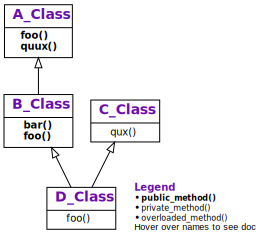

In [32]:
display_class_hierarchy(D_Class, project='debuggingbook')

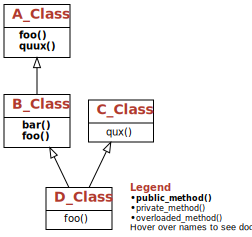

In [33]:
display_class_hierarchy(D_Class, project='fuzzingbook')

## Synopsis

The function `display_class_hierarchy()` function shows the class hierarchy for the given class (or list of classes). The keyword parameter `public_methods`, if given, is a list of "public" methods to be used by clients (default: all methods with docstrings).

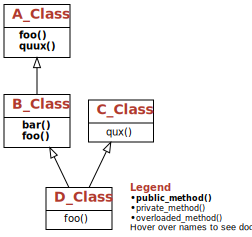

In [34]:
display_class_hierarchy(D_Class)

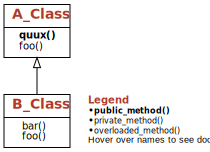

In [35]:
display_class_hierarchy([A_Class, B_Class],
                        public_methods=[
                            A_Class.quux,
                        ])

Enjoy!